## importing the libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Preprocess image function

In [2]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [3]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Load images

In [16]:
content_image = preprocess_image('C:/Users/nikhi/OneDrive/Desktop/practice/Screenshot 2023-11-19 204129.png')
style_image = preprocess_image("C:/Users/nikhi/OneDrive/Desktop/test.png")


## Content and Style layers

In [17]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

## Load VGG19 model

In [18]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Create the model
outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
model = Model(inputs=vgg.input, outputs=outputs)

## Define the style and content loss functions

In [19]:
def compute_style_loss(base_style, target_style):
    # Add extra dimension if needed
    if len(base_style.shape) == 3:
        base_style = tf.expand_dims(base_style, axis=0)
    if len(target_style.shape) == 3:
        target_style = tf.expand_dims(target_style, axis=0)

    base_style_gram = gram_matrix(base_style)
    target_style_gram = gram_matrix(target_style)
    return tf.reduce_mean(tf.square(base_style_gram - target_style_gram))


In [20]:
def compute_content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))

# Gram matrix function
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

## Compute loss function

In [21]:
def compute_loss(model_outputs, style_targets, content_targets, style_weight, content_weight):
    style_output_features = model_outputs[:len(style_layers)]
    content_output_features = model_outputs[len(style_layers):]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(len(style_layers))
    for target_style, comb_style in zip(style_targets, style_output_features):
        style_score += weight_per_style_layer * compute_style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(len(content_layers))
    for target_content, comb_content in zip(content_targets, content_output_features):
        content_score += weight_per_content_layer * compute_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    return total_loss

## Train step function

In [22]:
def train_step(image, model, optimizer, style_targets, content_targets, style_weight, content_weight):
    with tf.GradientTape() as tape:
        outputs = model(image)
        loss = compute_loss(outputs, style_targets, content_targets, style_weight, content_weight)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, -1, 1))

## initialization optimizer

In [23]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## style and content weights

In [24]:
style_weight = 1.0
content_weight = 1.0

# Initialize the target image for training
target_image = tf.Variable(content_image)


In [25]:
def get_style_and_content_features(model, style_image, content_image):
    # Combine the images into one batch
    combined_images = tf.concat([style_image, content_image], axis=0)

    # Pass the images through the model and get the outputs
    outputs = model(combined_images)

    # Separate the style and content representations
    style_features = outputs[:len(style_layers)]
    content_features = outputs[len(style_layers):]

    # Extract the style and content features from the respective layers
    style_features = [style_layer[0] for style_layer in style_features]
    content_features = [content_layer[1] for content_layer in content_features]

    return style_features, content_features

# Compute the style and content targets
style_targets, content_targets = get_style_and_content_features(model, style_image, content_image)


In [26]:
style_targets, content_targets = get_style_and_content_features(model, style_image, content_image)

# Training loop
epochs = 10
for n in range(epochs):
    train_step(target_image, model, optimizer, style_targets, content_targets, style_weight, content_weight)
    print(f"Train step: {n}")

Train step: 0
Train step: 1
Train step: 2
Train step: 3
Train step: 4
Train step: 5
Train step: 6
Train step: 7
Train step: 8
Train step: 9


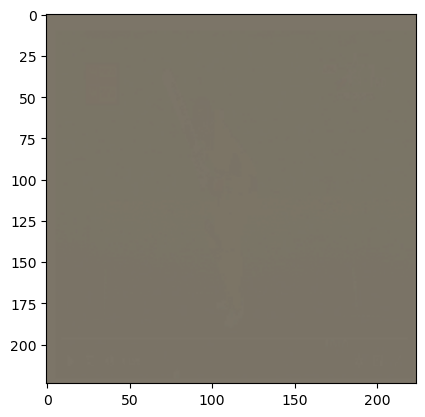

In [27]:
final_img = target_image.numpy()
plt.imshow(deprocess_img(final_img))
plt.show()